# Predicting the forest fire damage

This project aims to predict the extent of fire damage to a forest. We'll start with a reference model and then iterate with various optimizing tools.

The dataset is from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Forest+Fires), which contains information on fires, along with the resulting damage and associated meteorological data.

## Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector

## Columns' Information

- `X` - x-axis spatial coordinate within the Montesinho park map: 1 to 9
- `Y` - y-axis spatial coordinate within the Montesinho park map: 2 to 9
- `month` - month of the year: 'jan' to 'dec' 
- `day` - day of the week: 'mon' to 'sun'
- `FFMC` - FFMC index from the FWI system: 18.7 to 96.20; (Fine Fuel Moisture Code, a numeric rating of the moisture content of litter and other cured fine fuels)
- `DMC` - DMC index from the FWI system: 1.1 to 291.3; (Duff Moisture Code, represents fuel moisture of decomposed organic material underneath the litte)
- `DC` - DC index from the FWI system: 7.9 to 860.6; (Drought Code, is a numeric rating of the average moisture content of deep, compact organic layers)
- `ISI` - ISI index from the FWI system: 0.0 to 56.10; (Initial Spread Index, is a numeric rating of the expected rate of fire spread)
- `temp` - temperature in Celsius degrees: 2.2 to 33.30
- `RH` - relative humidity in %: 15.0 to 100
- `wind` - wind speed in km/h: 0.40 to 9.40 
- `rain` - outside rain in mm/m2 : 0.0 to 6.4 
- `area` - the burned area of the forest (in ha): 0.00 to 1090.84 

## Data Review

In [2]:
fires = pd.read_csv("fires.csv")
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [3]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [4]:
fires.describe()

,Unnamed: 0,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,469.000000,496.000000,474.000000,515.000000,496.000000,487.000000,482.000000,485.000000,517.000000
mean,259.000000,4.669246,4.299807,90.580384,111.195363,550.673418,9.018835,18.884677,44.381930,4.021784,0.023093,12.847292
std,149.389312,2.313778,1.229900,5.698137,64.008450,246.061309,4.564890,5.748318,16.180372,1.794460,0.305532,63.655818
min,1.000000,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,130.000000,3.000000,4.000000,90.200000,70.800000,441.200000,6.450000,15.475000,33.000000,2.700000,0.000000,0.000000
50%,259.000000,4.000000,4.000000,91.600000,108.300000,664.500000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,388.000000,7.000000,5.000000,92.800000,141.575000,713.900000,10.750000,22.725000,53.500000,4.900000,0.000000,6.570000
max,517.000000,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


Findings:
- The dataset has 517 observations with 13 features
- One of the observations is just a index column came from the initial dataset
- `month` and `day` columns are `object` data types, rest are numeric
- 8 columns have missing value

## Data Processing

### Outcome variable - `area`

Lets take a look on the outcome distribution

C:\Users\JMtan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


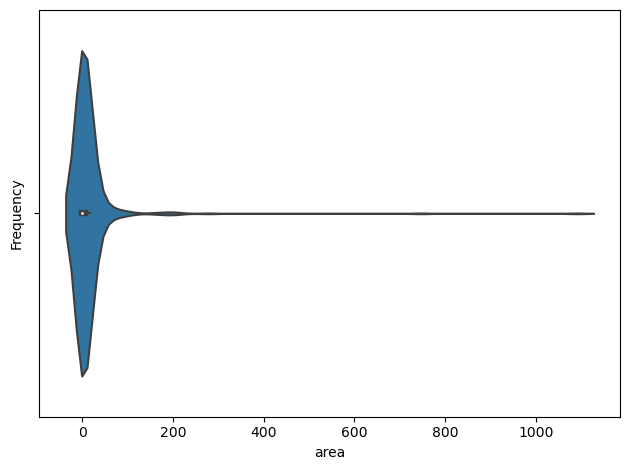

In [5]:
sns.violinplot(fires["area"])
plt.ylabel('Frequency')
plt.tight_layout()

It's highly right skewed towards 0.0, thus it may make sense to model with the logarithm transform. Lets plot the outcome again with log transformation (adding value 1 to avoid the error of log0, and to keep 0 to 0)

C:\Users\JMtan\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


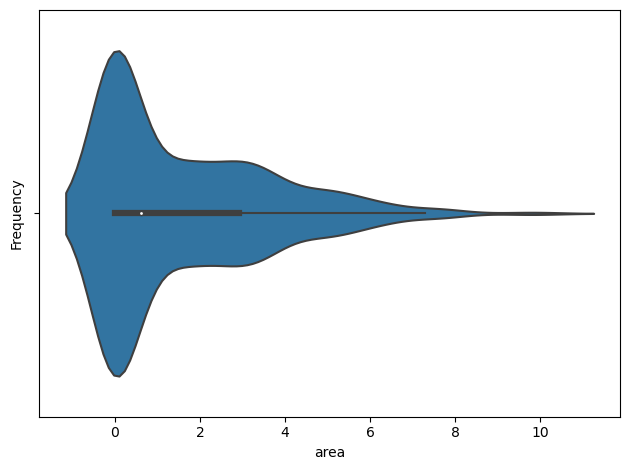

In [6]:
sns.violinplot(np.log2(fires["area"]+1))
plt.ylabel('Frequency')
plt.tight_layout()

Still with right skewed but shorter tail, but better now. Let add to our dataset.

In [7]:
fires['log_area'] = np.log(fires['area']+1)

### non-numeric variables

`month` and `day` columns are as object data types, we need to convert them to numerical so that can be used in the scikit-learn models. Let check the distribution of this 2 variables before doing the transformation

#### `month`

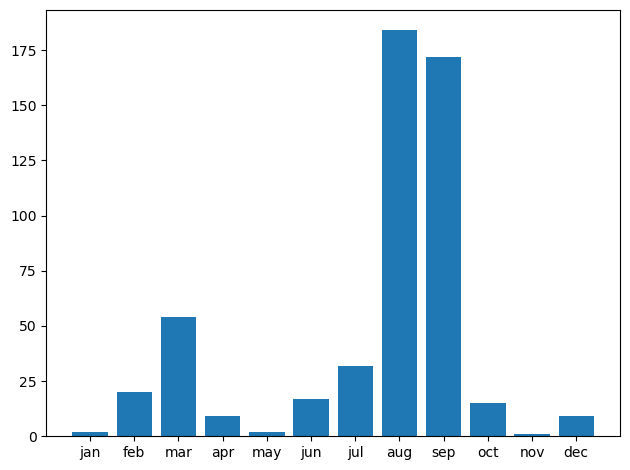

In [8]:
# Define the order
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
               'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# Convert to categorical with the defined order
month_col = pd.Categorical(fires['month'], categories=month_order, ordered=True)

val_cnt = month_col.value_counts()
plt.bar(val_cnt.index, val_cnt.values)
plt.tight_layout()
plt.show()

Was planning to transform this variable to 4 seasons, but dont make sense based on the frequency plot. Instead, we should group the months based on the actual fire risk. Also, having disjointed group (i.e. Mar+Jul for moderate risk) may not be appropriate as the fire risk is often influenced by gradual seasonal transitions rather than abrupt jumps. Thus, we'll follow the below three groups:
- Low: Oct to Feb
- Moderate: March to July
- Peak: August & September

In [9]:
# comvert `month` to `mth_low`/ `mth_moder`/ `mth_peak` - 1 for yes and 0 for no
fires['mth_low'] = fires['month'].isin(['oct', 'nov', 'dec', 'jan', 'feb']).astype('int64')
fires['mth_moder'] = fires['month'].isin(['mar', 'apr', 'may', 'jun', 'jul']).astype('int64')
fires['mth_peak'] = fires['month'].isin(['aug', 'sep']).astype('int64')

#### `day`

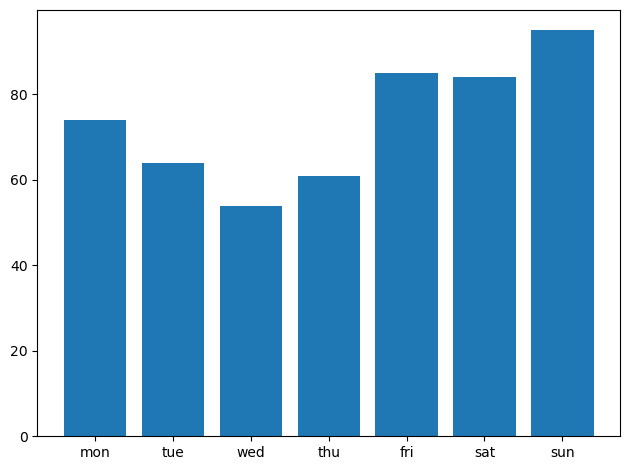

In [10]:
## day column
# Define the order
day_order = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']

# Convert to categorical with the defined order
day_col = pd.Categorical(fires['day'], categories=day_order, ordered=True)

val_cnt = day_col.value_counts()
plt.bar(val_cnt.index, val_cnt.values)
plt.tight_layout()
plt.show()

The easiest thought is to transform to weekday and weekend, but we should include Fri into the weekend group, not only it has a high frequency, also some contries tend to be leisure or dismiss earlier on Friday. Thus, we'll grouping as:
- Weekday: Mon to Thu
- Weekday: Fri to Sun

In [11]:
# convert `day` to weekend, 1 or 0
fires['weekend'] = fires['day'].isin(['fri', 'sat', 'sun']).astype('int64')

In [12]:
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,mth_low,mth_moder,mth_peak,weekend
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0,0.0,0,1,0,1
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0,0.0,1,0,0,0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0,0.0,1,0,0,1
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0,0.0,0,1,0,1
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0,0.0,0,1,0,1


### Missing Values

First of all, let do a summary regarding the missing values are concentrate on only few observations (can remove the line) or spread around the dataset (need imputation)

In [13]:
missing_counts = fires.isna().sum(axis=1)
missing_counts.value_counts().sort_index()

0    329
1    148
2     36
3      4
dtype: int64

From above, we can see that most of the missing values locate at a observation alone, we need to impute them. For those observations have 2 or 3 missing values, although we can remove the lines, but considering we have >10 features, we can remain tham and do imputation as well.

In [14]:
# isolate out the non-numeric column for the imputer
num_cols = fires.select_dtypes(include=['number']).columns
excluded_cols = fires.columns.difference(num_cols)

# Apply KNNImputer only on numeric columns
imp = KNNImputer()
imputing = imp.fit_transform(fires[num_cols])
imputed_fires = pd.DataFrame(imputing, columns=num_cols)

# recombine all
new_fires = pd.concat([fires[excluded_cols], imputed_fires], axis=1)

new_fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   day         517 non-null    object 
 1   month       517 non-null    object 
 2   Unnamed: 0  517 non-null    float64
 3   X           517 non-null    float64
 4   Y           517 non-null    float64
 5   FFMC        517 non-null    float64
 6   DMC         517 non-null    float64
 7   DC          517 non-null    float64
 8   ISI         517 non-null    float64
 9   temp        517 non-null    float64
 10  RH          517 non-null    float64
 11  wind        517 non-null    float64
 12  rain        517 non-null    float64
 13  area        517 non-null    float64
 14  log_area    517 non-null    float64
 15  mth_low     517 non-null    float64
 16  mth_moder   517 non-null    float64
 17  mth_peak    517 non-null    float64
 18  weekend     517 non-null    float64
dtypes: float64(17), object(2)
mem

### Outliers

#### Detecting

Lets plot the histogram of each features.

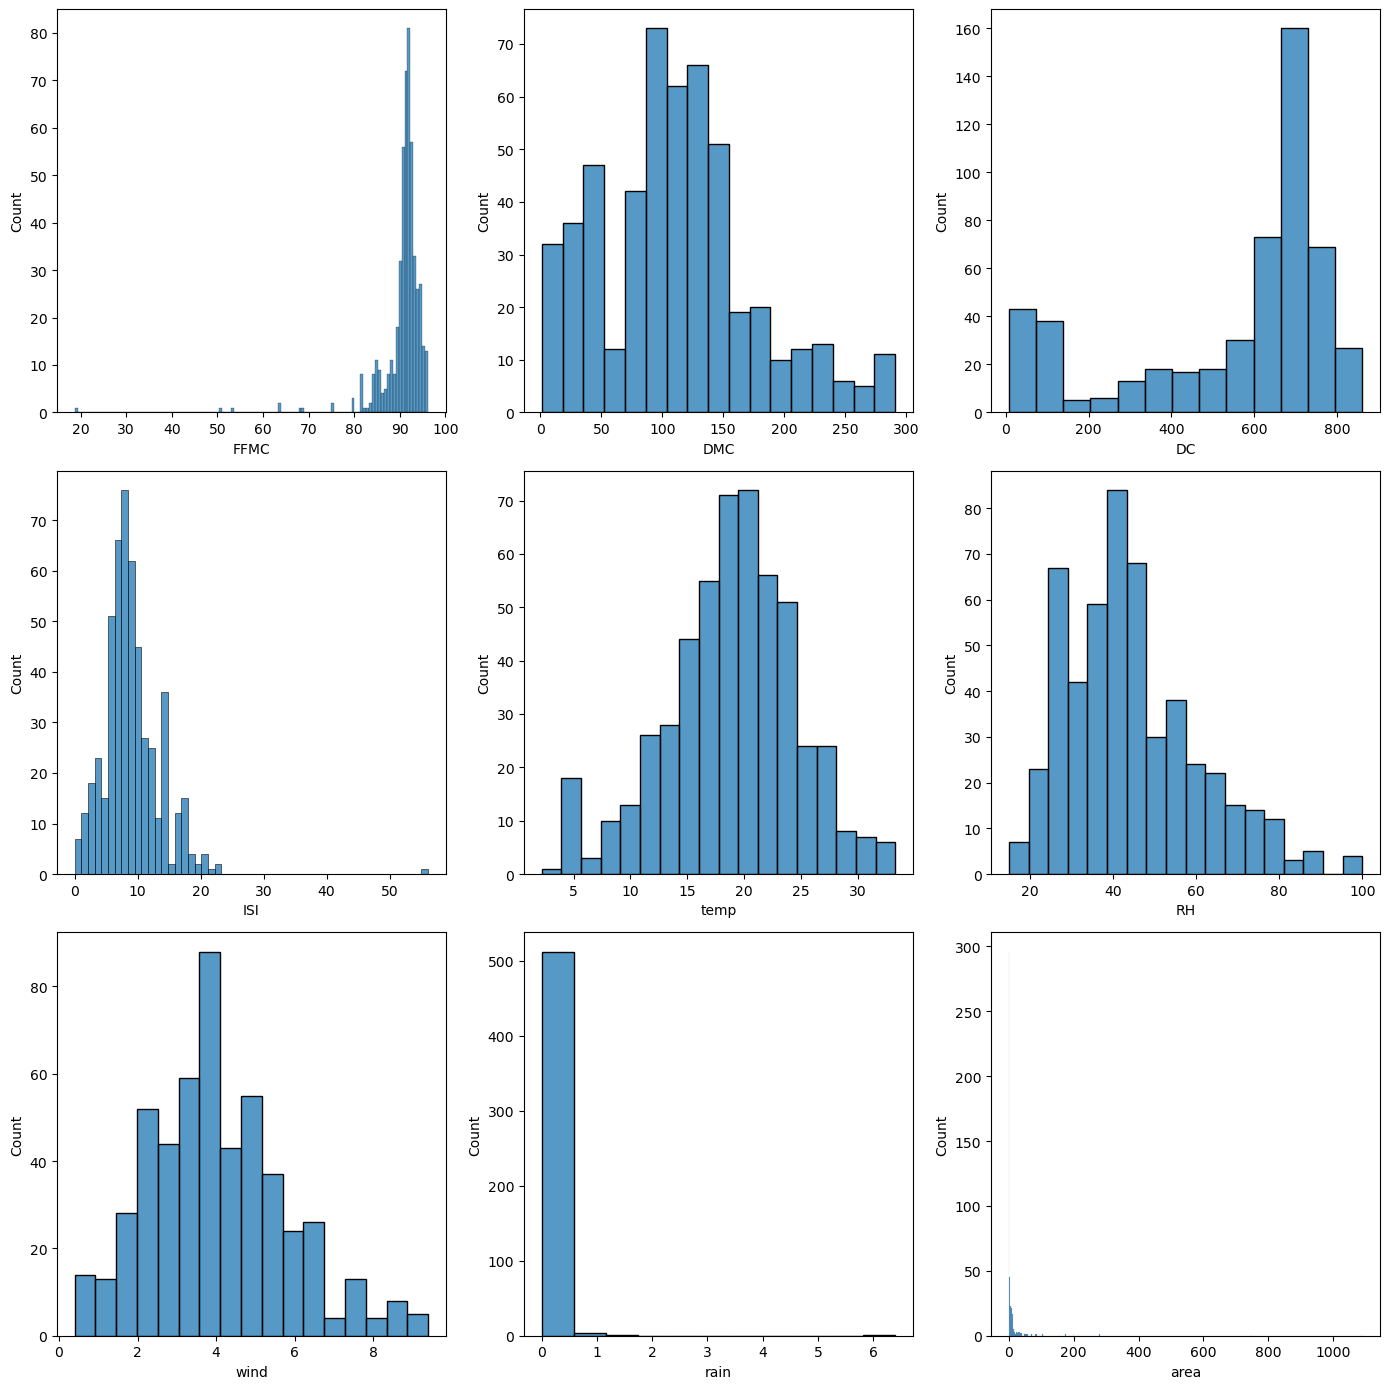

In [15]:
to_check = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']
plt.figure(figsize=(14, 14))
for i, f in enumerate(to_check, start=1):
    plt.subplot(3, 3, i)
    
    sns.histplot(new_fires[f])
    
plt.tight_layout()
plt.show()

Findings:
- `FFMC`, `ISI`, `rain`, `area` have potential outliers
- `temp` is normal distribution; `DMC`, `RH`, `wind` are quite skewed but close to normal
- Rest features are skewed distribution

Next, we'll use IQR and Z-Score to check the exact outliers in our data.
- Since Z-score assumes normality, we can only use it on `temp`, `DMC`, `RH`, and `wind`
- Rest features will use IQR

In [16]:
norm_features = ['temp', 'DMC', 'RH', 'wind']

# create an empty list to store all the outliers' index
outliers_index = []
for i in norm_features:
    series = new_fires[i]

     ## Z-Score
    z_scores = stats.zscore(series)
    # outliers are  Z-score outside of the range -3 to 3
    z_score_outliers = series[(z_scores < -3) | (z_scores > 3)]
    
    outliers_index.append(list(z_score_outliers.index))
    
    ## Print Results
    print(f"{series.name}:")
    print(f"- Observations: {len(z_score_outliers)}")
    print(f"- percentage (%): {len(z_score_outliers)/len(series)*100:.2f}%")

temp:
- Observations: 0
- percentage (%): 0.00%
DMC:
- Observations: 0
- percentage (%): 0.00%
RH:
- Observations: 4
- percentage (%): 0.77%
wind:
- Observations: 4
- percentage (%): 0.77%


In [17]:
non_norm_features = list(set(to_check)-set(norm_features))

for i in non_norm_features:
    series = new_fires[i]

    ## IQR 
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_outliers = series[(series < lower_bound) | (series > upper_bound)]
    
    outliers_index.append(list(iqr_outliers.index))
    
    ## Print Results
    print(f"{series.name}:")
    print(f"- Observations: {len(iqr_outliers)}")
    print(f"- percentage (%): {len(iqr_outliers)/len(series)*100:.2f}%")

DC:
- Observations: 1
- percentage (%): 0.19%
area:
- Observations: 63
- percentage (%): 12.19%
FFMC:
- Observations: 56
- percentage (%): 10.83%
rain:
- Observations: 8
- percentage (%): 1.55%
ISI:
- Observations: 23
- percentage (%): 4.45%


In [18]:
unique_outliers_index = list(sorted(set(i for j in outliers_index for i in j)))
len(unique_outliers_index)

140

After combine the outliers from all the features, we have 140 observations to be removed. However, it's about 30% of our data, which will harm our modeling if we remove them. Also, we dont have any additional information or domain expertise to decide which to remove and which to remain. Thus, we're not going to remove any observations for now, may consider if we have a bad result with those 'outliers'.

### Unnecessary Features

We're going to remove the following features from our dataset:
- `Unnamed: 0`: just the index from the initial data
- `month`: already transformed to - `mth_low`, `mth_moder`, `mth_peak`
- `day`: already transformed to - `weekend`
- `area`: : already transformed to - `log_area`

In [19]:
new_fires.drop(['Unnamed: 0', 'month', 'day', 'area'], axis=1, inplace=True)
new_fires.head()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,mth_low,mth_moder,mth_peak,weekend
0,7.0,5.0,86.2,26.20,94.30,5.1,14.32,51.0,6.7,0.0,0.0,0.0,1.0,0.0,1.0
1,7.0,4.0,90.6,89.44,669.10,6.7,18.00,33.0,0.9,0.0,0.0,1.0,0.0,0.0,0.0
2,7.0,4.0,90.6,43.70,202.42,6.7,14.60,33.0,1.3,0.0,0.0,1.0,0.0,0.0,1.0
3,8.0,6.0,91.7,33.30,77.50,9.0,8.30,97.0,4.0,0.2,0.0,0.0,1.0,0.0,1.0
4,8.0,6.0,89.3,51.30,102.20,9.6,11.40,99.0,5.1,0.0,0.0,0.0,1.0,0.0,1.0


### Standardizing

Lets take a look again on the data statistics

In [20]:
new_fires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log_area,mth_low,mth_moder,mth_peak,weekend
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.601625,111.079768,547.464603,9.023946,18.870677,44.400387,4.018607,0.021663,1.111026,0.090909,0.220503,0.688588,0.510638
std,2.313778,1.229900,5.512658,63.685642,244.770948,4.558985,5.742600,15.802814,1.757670,0.295959,1.398436,0.287758,0.414987,0.463519,0.500371
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,70.800000,431.600000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,661.300000,8.400000,19.300000,42.000000,4.000000,0.000000,0.418710,0.000000,0.000000,1.000000,1.000000
75%,7.000000,5.000000,92.800000,142.400000,710.000000,10.800000,22.700000,53.000000,4.900000,0.000000,2.024193,0.000000,0.000000,1.000000,1.000000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,6.995620,1.000000,1.000000,1.000000,1.000000


Findings:
- `log_area` has value ranged from 0 to 7
- `X`, `Y`, `wind`, and `rain` have similar range as the outcome variable, so we can skip them.
- `mth_low`, `mth_moder`, `mth_peak`, and `weekend` had already transformed to boolean, so skip here.
- From the histohram above, `temp`, `DMC`, and `RH` are normal or close to normal, so we'll use StandardScaler() to scale
- `FFMC`, `DC`, and `ISI` are skewed distribution, so we'll use np.log2() for them

In [21]:
to_standard = ['temp', 'DMC', 'RH']
new_columns_name = ['std_temp', 'std_DMC', 'std_RH']

standard = StandardScaler()
standard_data = standard.fit_transform(new_fires[to_standard])

# convert to df format
standard_data = pd.DataFrame(standard_data, columns=new_columns_name)

In [22]:
to_log = ['FFMC', 'DC', 'ISI']

for i in to_log:
    new_name = f"log_{i}"
    new_fires[new_name] = np.log(new_fires[i]+1)

In [23]:
# combine scaled data
final_fires = new_fires.join(standard_data)

# remove those features that already transformed
final_fires.drop(['temp', 'DMC', 'RH', 'FFMC', 'DC', 'ISI'], axis=1, inplace=True)
final_fires.describe()

,X,Y,wind,rain,log_area,mth_low,mth_moder,mth_peak,weekend,log_FFMC,log_DC,log_ISI,std_temp,std_DMC,std_RH
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,5.170000e+02,5.170000e+02,5.170000e+02
mean,4.669246,4.299807,4.018607,0.021663,1.111026,0.090909,0.220503,0.688588,0.510638,4.514556,6.054185,2.204281,3.118073e-16,6.785889e-17,9.706399e-17
std,2.313778,1.229900,1.757670,0.295959,1.398436,0.287758,0.414987,0.463519,0.500371,0.087959,0.927788,0.474827,1.000969e+00,1.000969e+00,1.000969e+00
min,1.000000,2.000000,0.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.980619,2.186051,0.000000,-2.905796e+00,-1.728589e+00,-1.862255e+00
25%,3.000000,4.000000,2.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.513055,6.069814,2.014903,-5.875286e-01,-6.330906e-01,-7.221137e-01
50%,4.000000,4.000000,4.000000,0.000000,0.418710,0.000000,0.000000,1.000000,1.000000,4.528289,6.495719,2.240710,7.483350e-02,-4.369054e-02,-1.520433e-01
75%,7.000000,5.000000,4.900000,0.000000,2.024193,0.000000,0.000000,1.000000,1.000000,4.541165,6.566672,2.468100,6.674733e-01,4.922706e-01,5.447095e-01
max,9.000000,9.000000,9.400000,6.400000,6.995620,1.000000,1.000000,1.000000,1.000000,4.576771,6.758791,4.044804,2.515115e+00,2.832582e+00,3.521744e+00


## Features vs Outcome

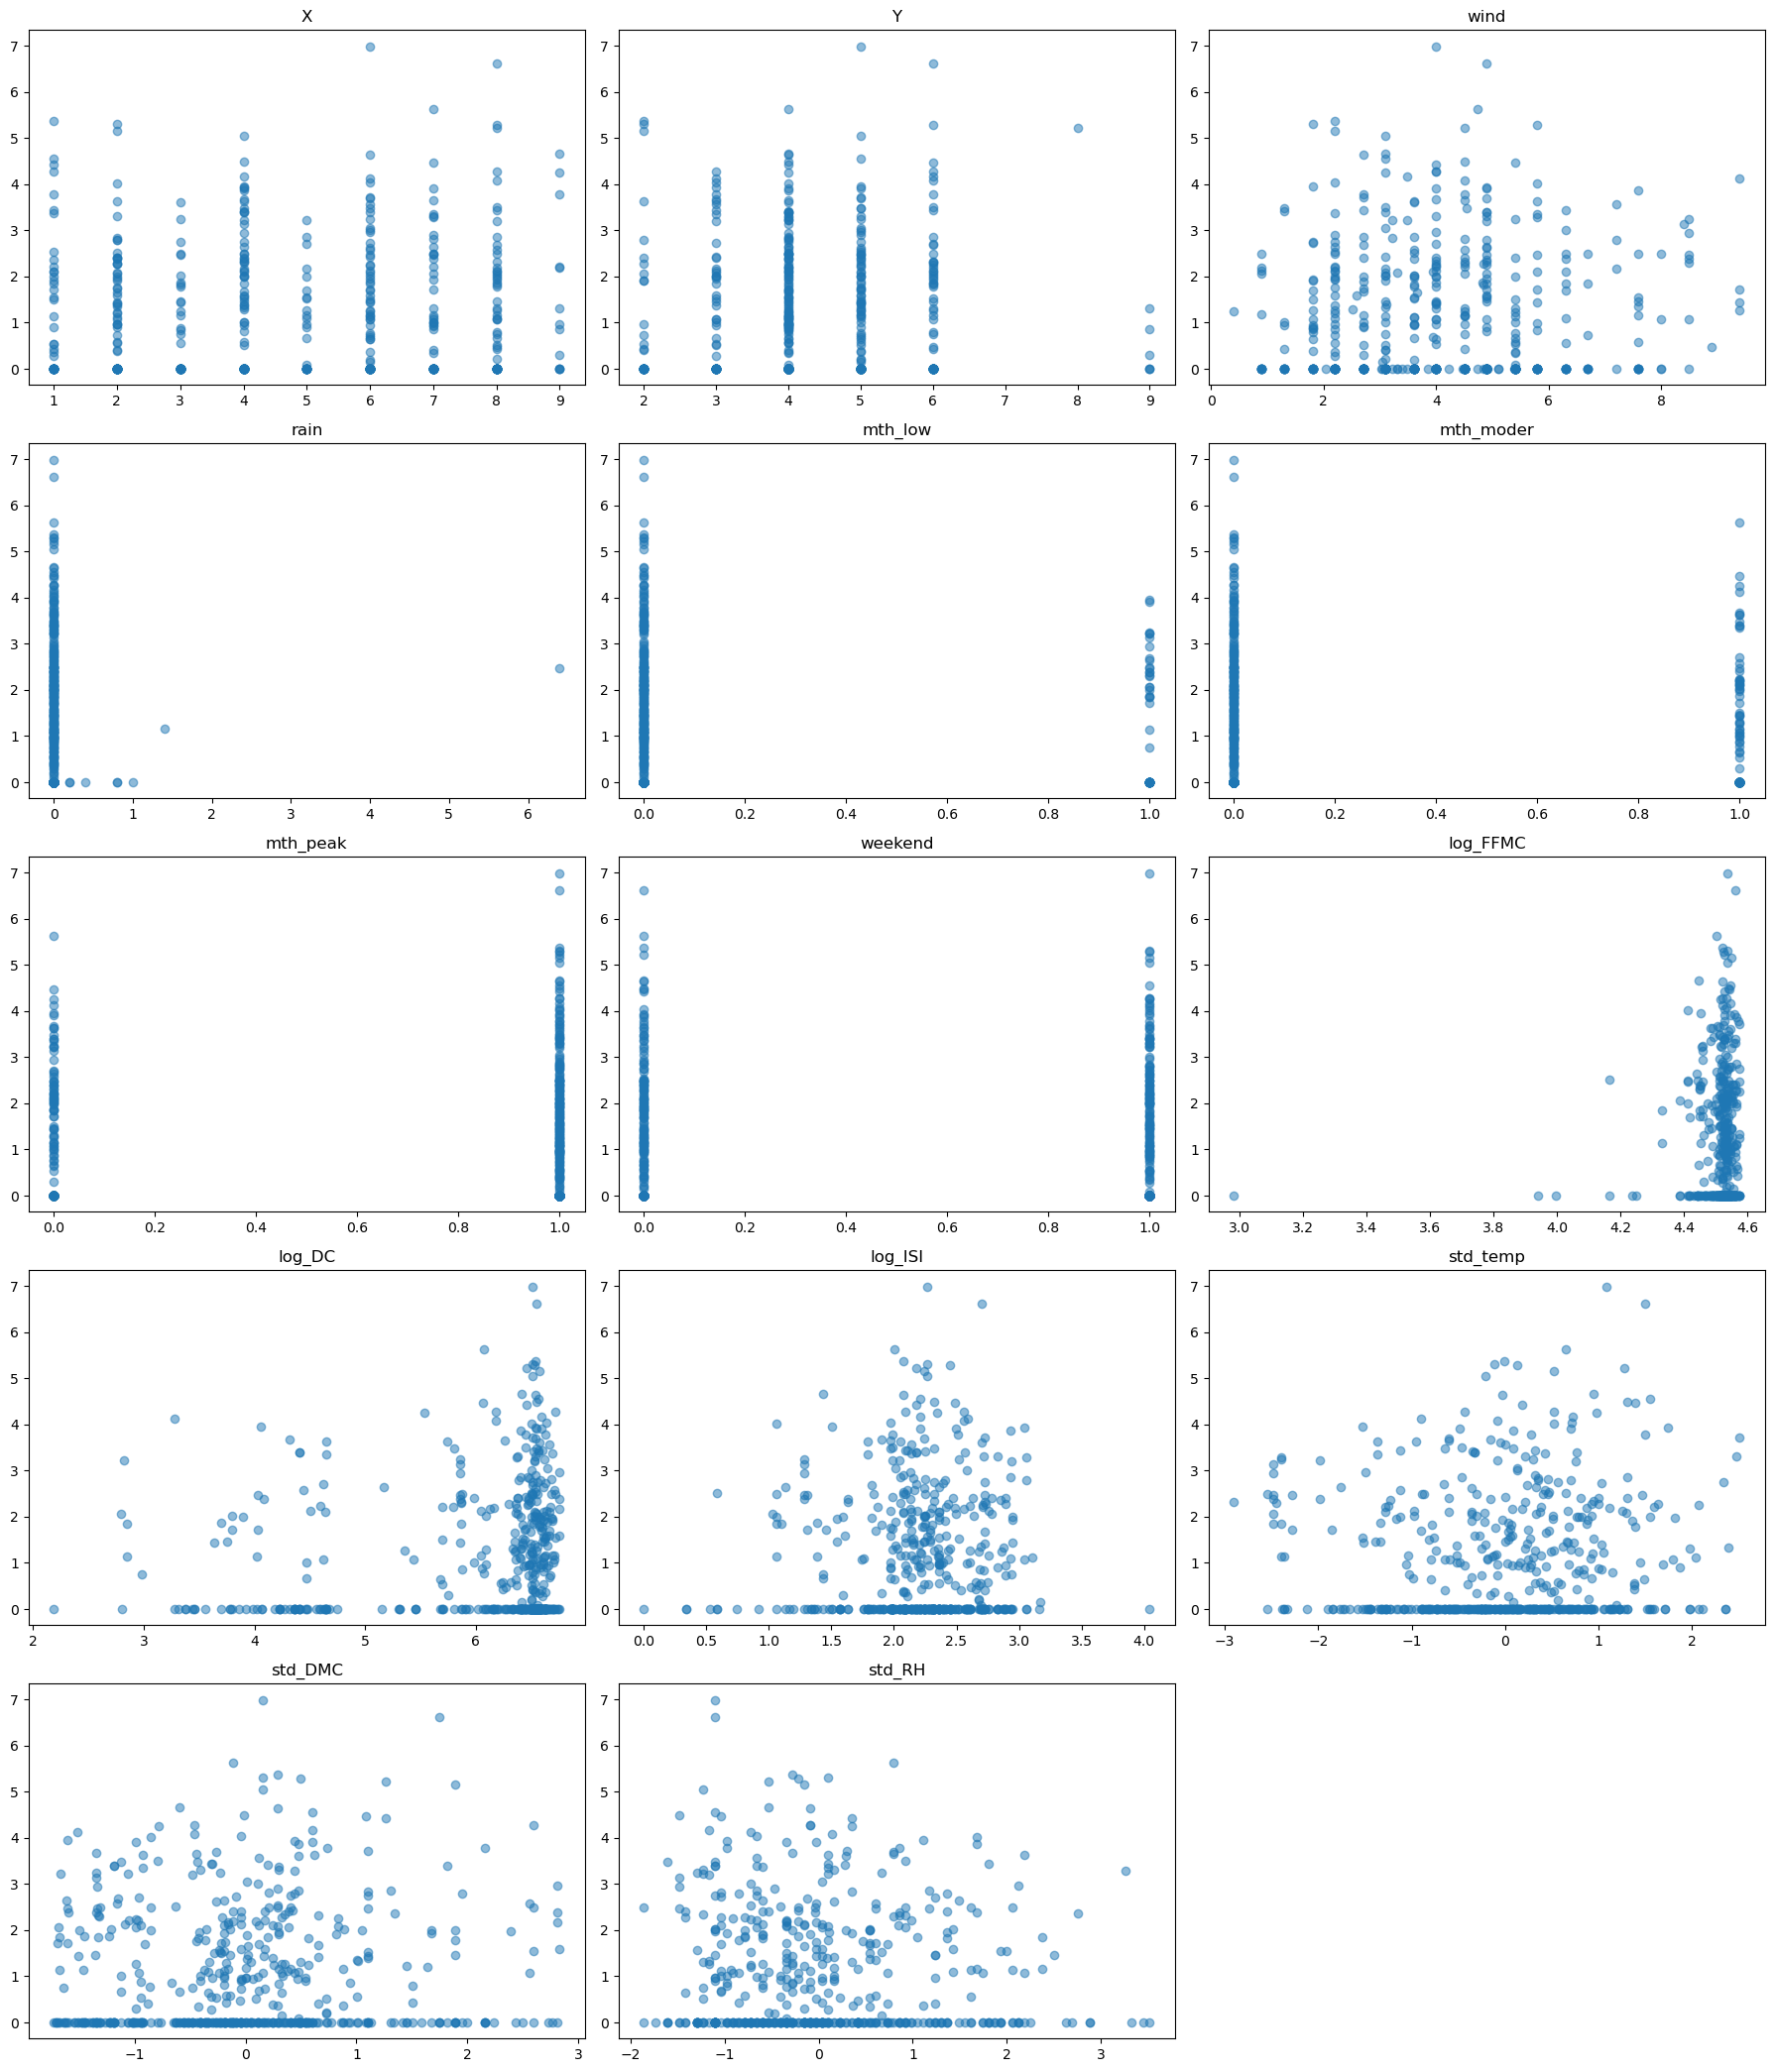

In [24]:
X = final_fires.drop("log_area", axis=1)

plt.figure(figsize=(18, 21))
for i, f in enumerate(X, start=1):
    plt.subplot(5, 3, i)
    plt.scatter(final_fires[f], final_fires['log_area'], alpha=0.5)
    plt.title(f)
plt.tight_layout()
plt.show()

- `wind`, `std_temp`, `std_DMC`, and `std_RH` show some spread in the outcome variable.
- Relatively， `rain`, `log_DC`, `log_ISI`, and `log_FFMC` show more concentrate.

### Correlation

In [25]:
correlations = []
for i, j in enumerate(X, 1):
    corr, p = stats.pearsonr(final_fires[j], final_fires['log_area'])
    correlations.append({
        'Feature': final_fires[j].name,
        'Correlation': abs(corr),
        'P-value': p})
    
# convert to df
corr_df = pd.DataFrame(correlations)
corr_df = corr_df.round(4)
corr_df = corr_df.sort_values('Correlation', ascending=False)

In [26]:
corr_df

,Feature,Correlation,P-value
9,log_DC,0.0783,0.0752
5,mth_moder,0.0750,0.0886
2,wind,0.0666,0.1305
0,X,0.0620,0.1593
12,std_DMC,0.0565,0.1994
8,log_FFMC,0.0486,0.2704
6,mth_peak,0.0479,0.2773
13,std_RH,0.0469,0.2875
11,std_temp,0.0434,0.3241
1,Y,0.0388,0.3782


Suprising that the highest correlation is 0.0783 and the lowest P-value is 0.0752, suggesting weak statistical significance.

Thus, we cant select fetures based on the relationship and correlation with the outcome, lets proceed to the feature selection

## Feature Selection 

In [27]:
y = final_fires['log_area']
X = final_fires.drop('log_area', axis=1)

linear_model = LinearRegression()

### Forward Selection

In [28]:
for i in range(2, 14, 2):
    forward = SequentialFeatureSelector(estimator=linear_model,
                                        n_features_to_select=i,
                                        direction="forward")
    forward.fit(X, y)
    features = forward.get_feature_names_out()
    new_X = final_fires[features]
    
    model = LinearRegression()
    model.fit(new_X, y)
    accuracy = model.score(new_X, y)
    
    print(f"the best {forward.n_features_to_select_} features: {features}")
    print(f" --> score: {round(accuracy, 4)}")

the best 2 features: ['X' 'log_DC']
 --> score: 0.0107
the best 4 features: ['X' 'wind' 'log_FFMC' 'log_DC']
 --> score: 0.0175
the best 6 features: ['X' 'wind' 'mth_moder' 'mth_peak' 'log_FFMC' 'log_DC']
 --> score: 0.0224
the best 8 features: ['X' 'wind' 'mth_low' 'mth_moder' 'mth_peak' 'weekend' 'log_FFMC' 'log_DC']
 --> score: 0.0224
the best 10 features: ['X' 'wind' 'mth_low' 'mth_moder' 'mth_peak' 'weekend' 'log_FFMC' 'log_DC'
 'log_ISI' 'std_RH']
 --> score: 0.0269
the best 12 features: ['X' 'Y' 'wind' 'mth_low' 'mth_moder' 'mth_peak' 'weekend' 'log_FFMC'
 'log_DC' 'log_ISI' 'std_DMC' 'std_RH']
 --> score: 0.0283


### Backward Selection

In [29]:
for i in range(2, 14, 2):
    backward = SequentialFeatureSelector(estimator=linear_model,
                                        n_features_to_select=i,
                                        direction="backward")
    backward.fit(X, y)
    features = backward.get_feature_names_out()
    new_X = final_fires[features]
    
    model = LinearRegression()
    model.fit(new_X, y)
    accuracy = model.score(new_X, y)
    
    print(f"the best {backward.n_features_to_select_} features: {features}")
    print(f" --> score: {round(accuracy, 4)}")

the best 2 features: ['X' 'log_DC']
 --> score: 0.0107
the best 4 features: ['X' 'wind' 'log_FFMC' 'log_DC']
 --> score: 0.0175
the best 6 features: ['X' 'wind' 'mth_moder' 'mth_peak' 'log_FFMC' 'log_DC']
 --> score: 0.0224
the best 8 features: ['X' 'wind' 'mth_low' 'mth_moder' 'mth_peak' 'weekend' 'log_FFMC' 'log_DC']
 --> score: 0.0224
the best 10 features: ['X' 'wind' 'mth_low' 'mth_moder' 'mth_peak' 'weekend' 'log_FFMC' 'log_DC'
 'log_ISI' 'std_RH']
 --> score: 0.0269
the best 12 features: ['X' 'Y' 'wind' 'mth_low' 'mth_moder' 'mth_peak' 'weekend' 'log_FFMC'
 'log_DC' 'log_ISI' 'std_DMC' 'std_RH']
 --> score: 0.0283


We get the same result from the `forward` and `backward` method. Overall, we have a bad result, with the highest accurcy just 0.0283. This matches the findings from the correlation part, regarding the features and outcome have a weak relationship, leading us to a bad result with linear regression. But notably that the more the features, the higher accuracy score.

Next, lets try to create few other models.

## Candidate Models

### Regularization

In [30]:
lasso = LassoCV(alphas=np.linspace(1, 10000, 100))
lasso.fit(X, y)
lasso_alpha = lasso.alpha_
lasso_coef = lasso.coef_
lasso_mse = mean_squared_error(y, lasso.predict(X))

print(f"alpha selected: {lasso_alpha}")
print(f"mse: {lasso_mse}")
print(f"coefficients: {lasso_coef}")

alpha selected: 10000.0
mse: 1.9518404861066627
coefficients: [ 0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0. -0.]


In [31]:
ridge = RidgeCV(alphas=np.linspace(1, 10000, 100))
ridge.fit(X, y)
ridge_alpha = ridge.alpha_
ridge_mse = mean_squared_error(y, ridge.predict(X))

coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': ridge.coef_})
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

print(f"alpha selected: {ridge_alpha}")
print(f"mse: {ridge_mse}")
coef_df

alpha selected: 1718.0
mse: 1.9275298763658408


,Feature,Coefficient
2,wind,0.027625
0,X,0.022674
9,log_DC,0.022292
13,std_RH,-0.015897
12,std_DMC,0.015413
5,mth_moder,-0.011395
11,std_temp,0.010784
1,Y,0.007712
6,mth_peak,0.006602
4,mth_low,0.004793


Findings
- LASSO tends to select higher alpha value, higher chance to forced coefficients to be zero, especially when the correlation of the features and outcome are low.
- Ridge model attempts to retain all the features after the regularization, although for the low correlation between features and outcome, but we can see that the coeficients' value are low
- Suprise that both method produce similar MSE value.

### Polynomial & Spline

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=369)

for i in range(1, 4):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    poly_X_train = poly.fit_transform(X_train)
    poly_X_test = poly.transform(X_test)

    poly_model = LinearRegression()
    poly_model.fit(poly_X_train, y_train)
    poly_mse = mean_squared_error(poly_model.predict(poly_X_test), y_test)

    print(f"(Degree={i}), mse = {round(poly_mse, 4)}")

(Degree=1), mse = 1.9989
(Degree=2), mse = 2.8427
(Degree=3), mse = 411010.281


From above, we can see that the MSE keep increasing as the degree increase, the best is when the degree equal to 1 with MSE = 1.999, but it's still higher than the Ridge and LASSO models

In [33]:
for j in range(2, 5):
    print(f"(n_knots = {j}):")
    for i in range(j, 3+j):
        spline = SplineTransformer(degree=i, n_knots=j)

        spline_X_train = spline.fit_transform(X_train)
        spline_X_test = spline.transform(X_test)

        spline_model = LinearRegression()
        spline_model.fit(spline_X_train, y_train)
        spline_mse = mean_squared_error(spline_model.predict(spline_X_test), y_test)

        print(f"- (Degree={i}), mse = {round(spline_mse, 4)}")

(n_knots = 2):
- (Degree=2), mse = 2.0436
- (Degree=3), mse = 2.1363
- (Degree=4), mse = 2.3792
(n_knots = 3):
- (Degree=3), mse = 2.3741
- (Degree=4), mse = 1491438698244.7866
- (Degree=5), mse = 228321349938503.66
(n_knots = 4):
- (Degree=4), mse = 505271312934310.3
- (Degree=5), mse = 2.6042
- (Degree=6), mse = 1.0269202039410092e+16


We get the similar reult, the higher the degree and n_knows, the higher the MSE. Also, the best result here is mse = 2.0017, which is higher then all the 3 models above.

## K-Fold Cross-Validation

Now that we have a few candidate models, let's evaluate all of them using k-fold cross-validation.

### Baseline Model

In [34]:
ref_model = LinearRegression()
ref_cross_val = cross_val_score(ref_model, X, y, n_jobs=-1,
                                scoring = "neg_mean_squared_error")

print("Avg MSE:", round(np.mean(ref_cross_val), 4), ", Std:", round(np.std(ref_cross_val), 4))

Avg MSE: -2.6539 , Std: 1.261


### Forward Selection

In [35]:
for i in range(2, 14, 2):
    forward = SequentialFeatureSelector(estimator=linear_model,
                                        n_features_to_select=i,
                                        direction="forward")
    forward.fit(X, y)
    f_features = forward.get_feature_names_out()
    f_new_X = final_fires[f_features]
    
    forward_model = LinearRegression()
    
    forward_cross_val = cross_val_score(forward_model, f_new_X, y, n_jobs=-1,
                                        scoring = "neg_mean_squared_error")
    
    print(f"Forward with {i} features: Avg MSE:", round(np.mean(forward_cross_val), 4), ", Std:", round(np.std(forward_cross_val), 4))

Forward with 2 features: Avg MSE: -2.1629 , Std: 1.0136
Forward with 4 features: Avg MSE: -2.1645 , Std: 0.9921
Forward with 6 features: Avg MSE: -2.19 , Std: 0.9965
Forward with 8 features: Avg MSE: -2.1971 , Std: 0.9939
Forward with 10 features: Avg MSE: -2.2256 , Std: 0.9898
Forward with 12 features: Avg MSE: -2.3362 , Std: 1.0242


Findings:
- Forward model with 2 features has the lowest absolute avg MSE value
- Forward model with 10 features has the lowest standard deviation value
- However, the forward model with 4 features seems better with a balanced on MSE and Std
    - compared to 2 features: MSE+0.0016, Std-0.0215
    - compared to 10 features: MSE-0.0611, Std+0.0023

As we know that both the `forward` and `backward` have the same features selection, so no need to do for `backward`

### Regularization

In [36]:
lasso = LassoCV(alphas=np.linspace(1, 10000, 100))
lasso_cross_val = cross_val_score(lasso, X, y, n_jobs=-1,
                                  scoring = "neg_mean_squared_error")

print("Avg MSE:", round(np.mean(lasso_cross_val), 4), ", Std:", round(np.std(lasso_cross_val), 4))

Avg MSE: -2.1737 , Std: 1.0143


It's better than the baseline model, but worse than the forward model.

In [37]:
ridge = RidgeCV(alphas=np.linspace(1, 10000, 100))
ridge_cross_val = cross_val_score(ridge, X, y, n_jobs=-1,
                                  scoring = "neg_mean_squared_error")

print("Avg MSE:", round(np.mean(ridge_cross_val), 4), ", Std:", round(np.std(ridge_cross_val), 4))

Avg MSE: -2.2728 , Std: 1.0334


It's better than the baseline model, but is the worst compared to the forward model and LASSO model.

### Polynomial & Spline

In [38]:
for i in range(2, 5):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    poly_X = poly.fit_transform(X)

    poly_model = LinearRegression()
    
    poly_cross_val = cross_val_score(poly_model, poly_X, y, n_jobs=-1,
                                     scoring = "neg_mean_squared_error")

    print(f"(Degree={i})", round(np.mean(poly_cross_val), 4), ", Std:", round(np.std(poly_cross_val), 4))

(Degree=2) -8.1531 , Std: 5.7881
(Degree=3) -1966173767.4903 , Std: 3548916537.2901
(Degree=4) -728334166463174.4 , Std: 904875407551033.1


The lowest MSE is with the lowest degree, but is the worst model for our dataset so far

In [39]:
for j in range(2, 5):
    print(f"n_knots={j}:")
    for i in range(1, 5):
        spline = SplineTransformer(degree=i, n_knots=j)

        spline_X = spline.fit_transform(X)

        spline_model = LinearRegression()
        
        spline_cross_val = cross_val_score(spline_model, spline_X, y, n_jobs=-1,
                                           scoring = "neg_mean_squared_error")

        print(f"-(Degree={i}): MSE=", round(np.mean(spline_cross_val), 4), ", Std=", round(np.std(spline_cross_val), 4))

n_knots=2:
-(Degree=1): MSE= -2.6528 , Std= 1.2599
-(Degree=2): MSE= -26.9612 , Std= 48.9072
-(Degree=3): MSE= -7.922508458691342e+19 , Std= 1.5845016917382683e+20
-(Degree=4): MSE= -6.987042191835269e+23 , Std= 1.3974084383670538e+24
n_knots=3:
-(Degree=1): MSE= -3.6758568318738262e+25 , Std= 7.351634319189174e+25
-(Degree=2): MSE= -3.354008663957773e+21 , Std= 6.614854309203825e+21
-(Degree=3): MSE= -1.5417966707046179e+22 , Std= 3.082966699548874e+22
-(Degree=4): MSE= -2.5328156754597705e+21 , Std= 5.065611079926992e+21
n_knots=4:
-(Degree=1): MSE= -6.522511015883785e+21 , Std= 1.2967250884396598e+22
-(Degree=2): MSE= -8.417840835802205e+20 , Std= 1.6833467590632758e+21
-(Degree=3): MSE= -7.325099149098715e+23 , Std= 1.4627277138739995e+24
-(Degree=4): MSE= -4.4904907804831347e+21 , Std= 8.96588491620255e+21


The model with 2 knots and 1 degree has the lowest MSE and standard deviation, but the result is similar with the baseline model.

## Best Model

The best model for our dataset is the forward model with 4 features, lets proceed to calculate and plot for the residuals.

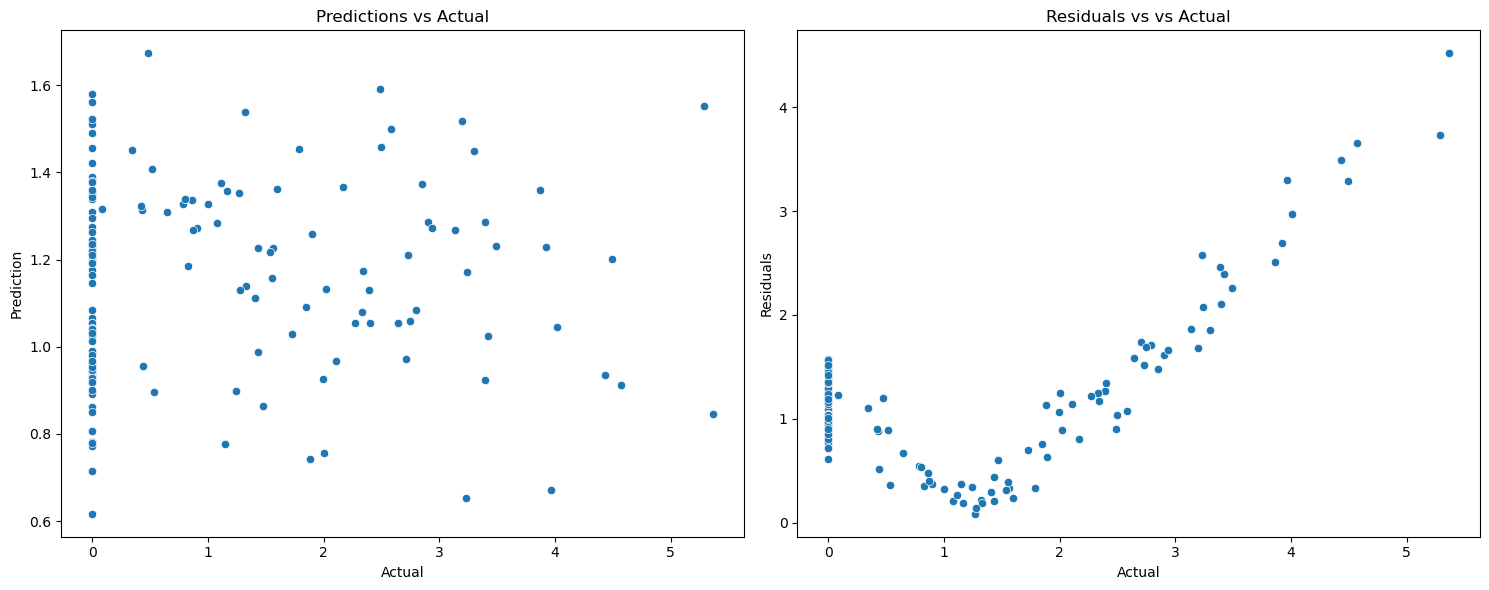

In [56]:
X = final_fires[['X', 'wind', 'log_FFMC', 'log_DC']]
y = final_fires['log_area']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=369)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
residuals = abs(y_pred - y_test)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(y=y_pred, x=y_test, ax=ax1)
ax1.set_title("Predictions vs Actual")
ax1.set_ylabel("Prediction")
ax1.set_xlabel("Actual")

sns.scatterplot(y=residuals, x=y_test, ax=ax2)
ax2.set_title("Residuals vs vs Actual")
ax2.set_ylabel("Residuals")
ax2.set_xlabel("Actual")

plt.tight_layout()
plt.show()

Predictions vs Actual:
- The predictions has a smaller range (0.6 to 1.6), which the range for the actual values is 0 to 6, indicating that the model might be biased or lacking variance.
- There isn't any obvious trend or patter on the graph, showing a poor correlation between predictions and the actual values

Predictions vs Residuals:
- As expected from the previous graph, the smallest residuals cluster at around 1.2.
- The residuals increasing with the actual values, indicating a heteroscedasticity

## Conclusion

This project was aim to develop a predictive model to estimate the area burned by fires. We went through many different models with tuning parameter but none of them meet our expectations for the predictions. Although some of them have small MSE but the predictions is horrible. However, this is anticipated, as all the features in the dataset have shown low correlation with the target variable, and limiting the model's ability

These findings highlight the necessity for additional data preprocessing, advanced feature engineering, trial of other types of non-linear models (i.e. decision trees, random forests), and possibly to include more relevant features.

This project underscores the importance of feature relevance in predictive modeling and provides a direction for future research and development.